# Image Classification
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
import problem_unittests as tests
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import problem_unittests as tests
import re
from matplotlib.backends.backend_pdf import PdfPages

In [28]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## Implement Preprocess Functions

In [33]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    return x/255.

#tests.test_normalize(normalize)

def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    rows = len(x)
    result = np.zeros((rows, 10), dtype=np.int)
    result[range(rows), x] = 1
    return result

#tests.test_one_hot_encode(one_hot_encode)

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [5]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is your first checkpoint.  If you ever decide to come back to this notebook or have to restart the notebook, you can start from here.  The preprocessed data has been saved to disk.

In [2]:
# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability. Implement the following functions
* Implement `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* Implement `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load your saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [3]:
def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, shape=(None, *image_shape), name='x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.int8, shape=(None, n_classes), name='y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name='keep_prob')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, you should implement the function `conv2d_maxpool` to apply convolution then max pooling:
* Create the weight and bias using `conv_ksize`, `conv_num_outputs` and the shape of `x_tensor`.
* Apply a convolution to `x_tensor` using weight and `conv_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.
* Add bias
* Add a nonlinear activation to the convolution.
* Apply Max Pooling using `pool_ksize` and `pool_strides`.
 * We recommend you use same padding, but you're welcome to use any padding.


In [4]:
w_initializer = lambda shape: tf.truncated_normal(shape)
b_initializer = lambda shape: tf.zeros(shape)

In [5]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides, name):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    depth = x_tensor.get_shape().as_list()[3]
    w = tf.Variable(w_initializer([*conv_ksize, depth, conv_num_outputs]), name='w' + name)
    b = tf.Variable(b_initializer([conv_num_outputs]), name='b' + name)
    conv = tf.nn.conv2d(x_tensor, w, [1, *conv_strides, 1], padding='SAME')
    conv = tf.nn.relu(conv + b)    
    conv_maxpool = tf.nn.max_pool(conv, [1, *pool_ksize, 1] , [1, *pool_strides, 1], padding='SAME')
    #print('Layer shape:', conv.get_shape().as_list())
    #print('Layer shape after pooling:', conv_maxpool.get_shape().as_list())
    return conv_maxpool

#tests.test_con_pool(conv2d_maxpool)

### Flatten Layer
Implement the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output should be the shape (*Batch Size*, *Flattened Image Size*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [6]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    s = x_tensor.get_shape().as_list()
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], s[1] * s[2] * s[3]])

#tests.test_flatten(flatten)

### Fully-Connected Layer
Implement the `fully_conn` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [7]:
def fully_conn(x_tensor, num_outputs, name):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    s = x_tensor.get_shape().as_list()
    w = tf.Variable(w_initializer([s[1], num_outputs]), name = 'w' + name)
    b = tf.Variable(b_initializer([num_outputs]), name = 'b' + name)
    fc = tf.matmul(x_tensor, w) + b
    fc = tf.nn.relu(fc)
    return fc

#tests.test_fully_conn(fully_conn)

### Output Layer
Implement the `output` function to apply a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). Shortcut option: you can use classes from the [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) or [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) packages for this layer. For more of a challenge, only use other TensorFlow packages.

**Note:** Activation, softmax, or cross entropy should **not** be applied to this.

In [8]:
def output(x_tensor, num_outputs, name):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    s = x_tensor.get_shape().as_list()
    w = tf.Variable(w_initializer([s[1], num_outputs]), name = 'w' + name)
    b = tf.Variable(b_initializer([num_outputs]), name = 'b' + name)
    o = tf.matmul(x_tensor, w) + b
    return o

#tests.test_output(output)

### Create Convolutional Model
Implement the function `conv_net` to create a convolutional neural network model. The function takes in a batch of images, `x`, and outputs logits.  Use the layers you created above to create this model:

* Apply 1, 2, or 3 Convolution and Max Pool layers
* Apply a Flatten Layer
* Apply 1, 2, or 3 Fully Connected Layers
* Apply an Output Layer
* Return the output
* Apply [TensorFlow's Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout) to one or more layers in the model using `keep_prob`. 

In [9]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv1 = conv2d_maxpool(x,     32,  (3,3), (1,1), (2,2), (2,2), '1')
    #conv1 = tf.nn.batch_normalization(conv1)
    conv2 = conv2d_maxpool(conv1, 64,  (3,3), (1,1), (2,2), (2,2), '2')        
    conv3 = conv2d_maxpool(conv2, 128, (3,3), (1,1), (2,2), (2,2), '3')        
    
    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    f = flatten(conv3)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc = fully_conn(f, 1024, name='fc1')
    fc = tf.nn.dropout(fc, keep_prob)
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    o = output(fc, 10, 'fc2')
    
    # TODO: return output
    return o


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

def minimize(optimizer, cost, return_gradients = False):
    if return_gradients:
        grads_and_vars = optimizer.compute_gradients(cost)
        # grads_and_vars is a list of tuples (gradient, variable)
        return optimizer.apply_gradients(grads_and_vars), grads_and_vars
    else:
        return optimizer.minimize(cost), None

def build_network():
    # Remove previous weights, bias, inputs, etc..
    tf.reset_default_graph()

    # Inputs
    x = neural_net_image_input((32, 32, 3))
    y = neural_net_label_input(10)
    keep_prob = neural_net_keep_prob_input()

    # Model
    logits = conv_net(x, keep_prob)

    # Name logits Tensor, so that is can be loaded from disk after training
    logits = tf.identity(logits, name='logits')

    # Loss and Optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
    
    optimizer, grads_and_vars = minimize(tf.train.AdamOptimizer(), cost, True)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

    #tests.test_conv_net(conv_net)
    return x, y, keep_prob, cost, optimizer, accuracy, grads_and_vars

In [10]:
x, y, keep_prob, cost, optimizer, accuracy, grads_vars = build_network()

## Train the Neural Network


In [11]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch, grads_vars):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    _, gv = session.run([optimizer, grads_vars], feed_dict={x: feature_batch, y:label_batch, keep_prob: keep_probability})
    return gv
#tests.test_train_nn(train_neural_network)

### Show Stats
Implement the function `print_stats` to print loss and validation accuracy.  Use the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  Use a keep probability of `1.0` to calculate the loss and validation accuracy.

In [12]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    c = session.run(cost, feed_dict={x: feature_batch, y:label_batch, keep_prob: 1.})
    acc = session.run(accuracy, feed_dict={x: valid_features, y:valid_labels, keep_prob: 1.})
    print('Loss=%.3f accuracy=%.1f' % (c, acc * 100.))
    return c, acc

### Train on a Single CIFAR-10 Batch


In [13]:
def get_color(name):
    if re.match('w[0-9]', name):
        return plt.cm.coolwarm(0)
    if re.match('b[0-9]', name):
        return plt.cm.coolwarm(1.)
    if re.match('wfc[0-9]', name):
        return plt.cm.PiYG(1.)
    if re.match('bfc[0-9]', name):
        return plt.cm.PiYG(0)
    return 'r'

In [14]:
def plot_histograms(grads_vars_values):
    plots = len(grads_vars_values)
    fig, ax = plt.subplots(nrows = 2, ncols = plots, figsize=(17,3))
    fig.subplots_adjust(hspace=.7)
    for i in range(plots):        
        grads = np.reshape(grads_vars_values[i][0], [-1])
        name = grads_vars_values[i][2]
        name = name[:name.find(':')]
        ax[0][i].hist(grads, color = get_color(name))
        ax[0][i].set_title('∇' + name, fontsize=14)
        ax[0][i].set_yticklabels([])
        values = np.reshape(grads_vars_values[i][1], [-1])
        ax[1][i].hist(values, color = get_color(name))
        ax[1][i].set_title(name, fontsize=14)
        ax[1][i].set_yticklabels([])     
    return fig

In [15]:
def plot_acc_loss(data):
    fig = plt.figure(figsize=(14,4))
    plt.subplot(121)
    plt.plot(data[:,0])
    plt.ylabel('Loss')    
    plt.xlabel('Epoch')
    plt.subplot(122)
    plt.plot(data[:,1])
    plt.ylabel('Accuracy')    
    plt.xlabel('Epoch')
    return fig

In [24]:
save_model_path = './image_classification'

def train_model(epochs = 50, batch_size = 512, keep_probability = .6, n_batches = 5, title = 's'):
    hist = []
    with PdfPages(title + '.pdf') as pdf:        
        with tf.Session() as sess:
            # Initializing the variables
            sess.run(tf.global_variables_initializer())

            # Training cycle
            for epoch in range(epochs):
                gv = []            
                for batch_i in range(1, n_batches + 1):        
                    for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                        gv = train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, grads_vars)

                    print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                    hist.append(print_stats(sess, batch_features, batch_labels, cost, accuracy))
                    
                if epoch % 2 == 0:
                    gv = [(*gv, grads_vars[i][1].name) for i, gv in enumerate(gv)]
                    pdf.savefig(plot_histograms(gv))

            pdf.savefig(plot_acc_loss(np.array(hist)))
            # Save Model
            saver = tf.train.Saver()
            save_path = saver.save(sess, save_model_path)

In [17]:
def xavier_inivializer(shape):
    fan_in = shape[0] if len(shape) < 3 else np.prod(shape[:3])
    fan_out = 0 if len(shape) == 1 else shape[-1]
    scale = np.sqrt(fan_in / 2)
    return tf.random_normal(shape, seed=0) / scale

In [19]:
def run(w_init, b_init, epochs = 5, batches = 5, title = 'test'):
    global x, y, keep_prob, cost, optimizer, accuracy, grads_vars, w_initializer, b_initializer
    w_initializer, b_initializer = w_init, b_init
    x, y, keep_prob, cost, optimizer, accuracy, grads_vars = build_network()    
    train_model(epochs = epochs, n_batches = batches, title = title)

Epoch  1, CIFAR-10 Batch 1:  Loss=2.052 accuracy=28.5
Epoch  1, CIFAR-10 Batch 2:  Loss=1.659 accuracy=40.4
Epoch  1, CIFAR-10 Batch 3:  Loss=1.446 accuracy=42.9
Epoch  1, CIFAR-10 Batch 4:  Loss=1.446 accuracy=46.6
Epoch  1, CIFAR-10 Batch 5:  Loss=1.415 accuracy=47.7
Epoch  2, CIFAR-10 Batch 1:  Loss=1.446 accuracy=52.1
Epoch  2, CIFAR-10 Batch 2:  Loss=1.249 accuracy=51.4
Epoch  2, CIFAR-10 Batch 3:  Loss=1.120 accuracy=55.2
Epoch  2, CIFAR-10 Batch 4:  Loss=1.112 accuracy=57.3
Epoch  2, CIFAR-10 Batch 5:  Loss=1.103 accuracy=57.8
Epoch  3, CIFAR-10 Batch 1:  Loss=1.150 accuracy=58.6
Epoch  3, CIFAR-10 Batch 2:  Loss=1.023 accuracy=56.7
Epoch  3, CIFAR-10 Batch 3:  Loss=1.000 accuracy=57.1
Epoch  3, CIFAR-10 Batch 4:  Loss=0.935 accuracy=60.8
Epoch  3, CIFAR-10 Batch 5:  Loss=0.909 accuracy=61.4
Epoch  4, CIFAR-10 Batch 1:  Loss=0.974 accuracy=62.9
Epoch  4, CIFAR-10 Batch 2:  Loss=0.907 accuracy=59.6
Epoch  4, CIFAR-10 Batch 3:  Loss=0.856 accuracy=62.5
Epoch  4, CIFAR-10 Batch 4: 

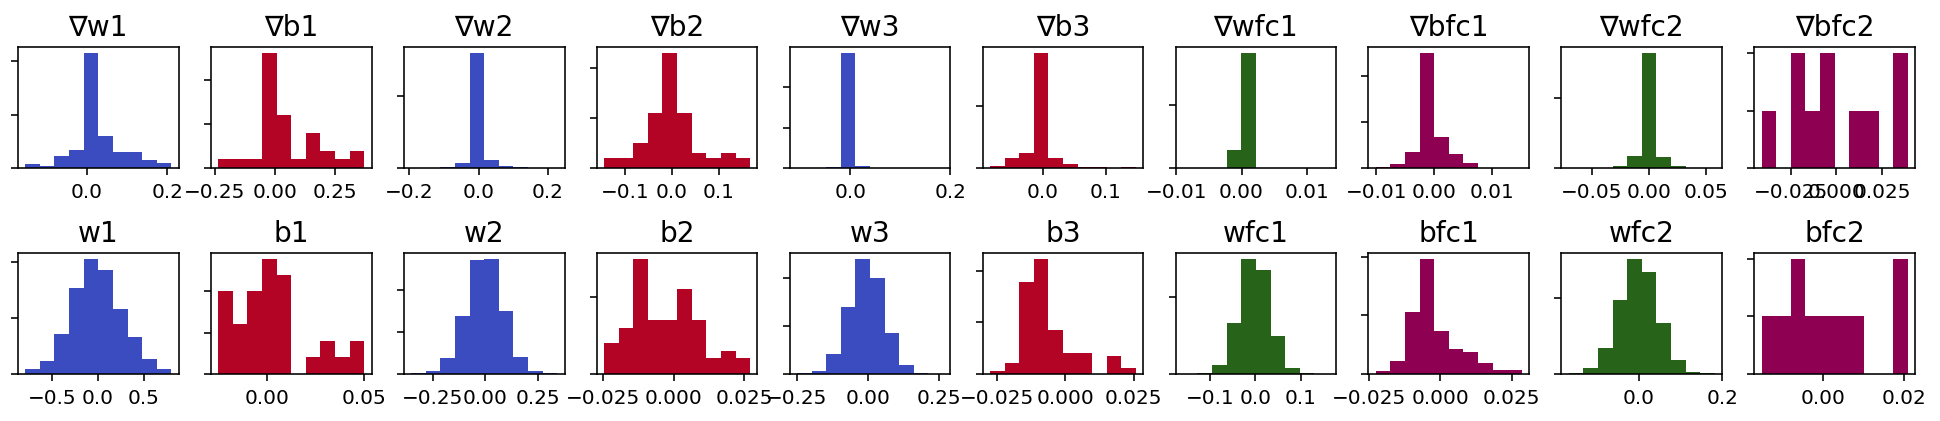

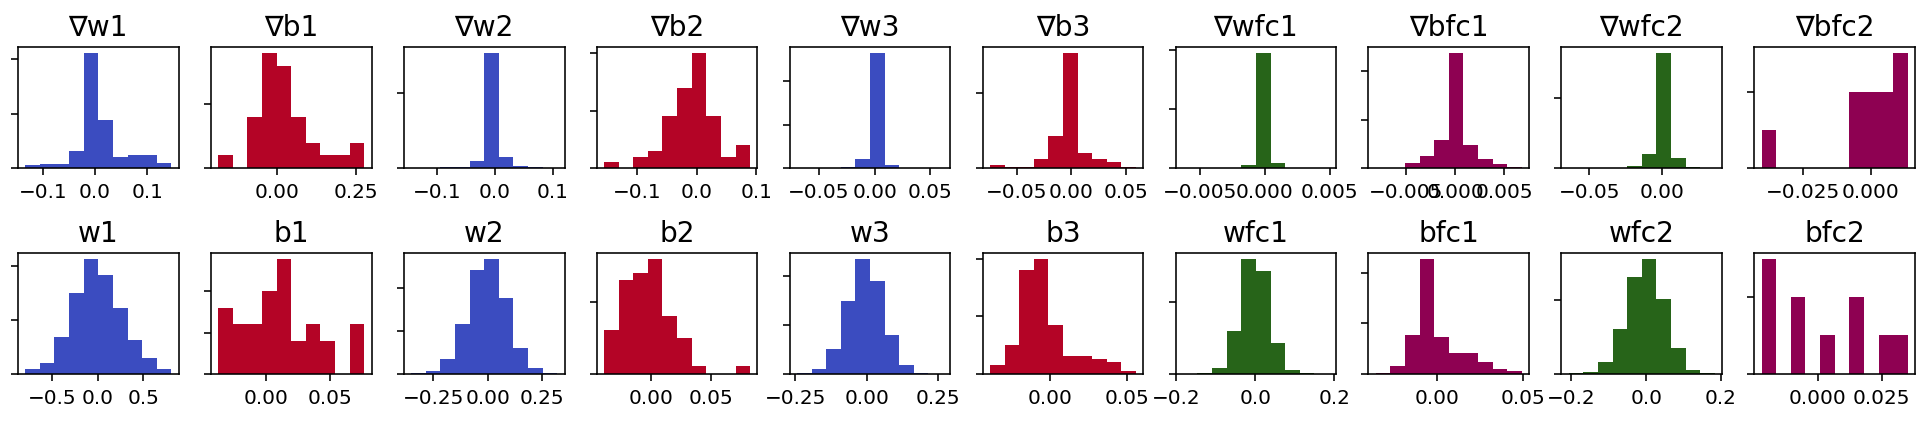

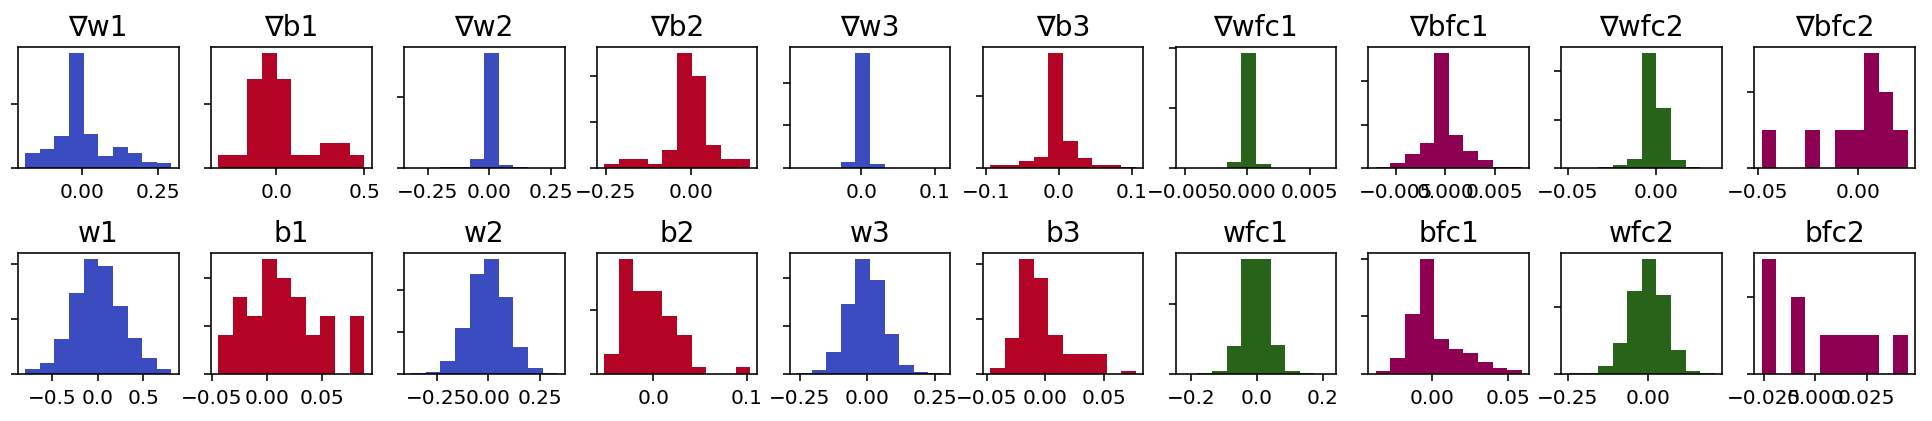

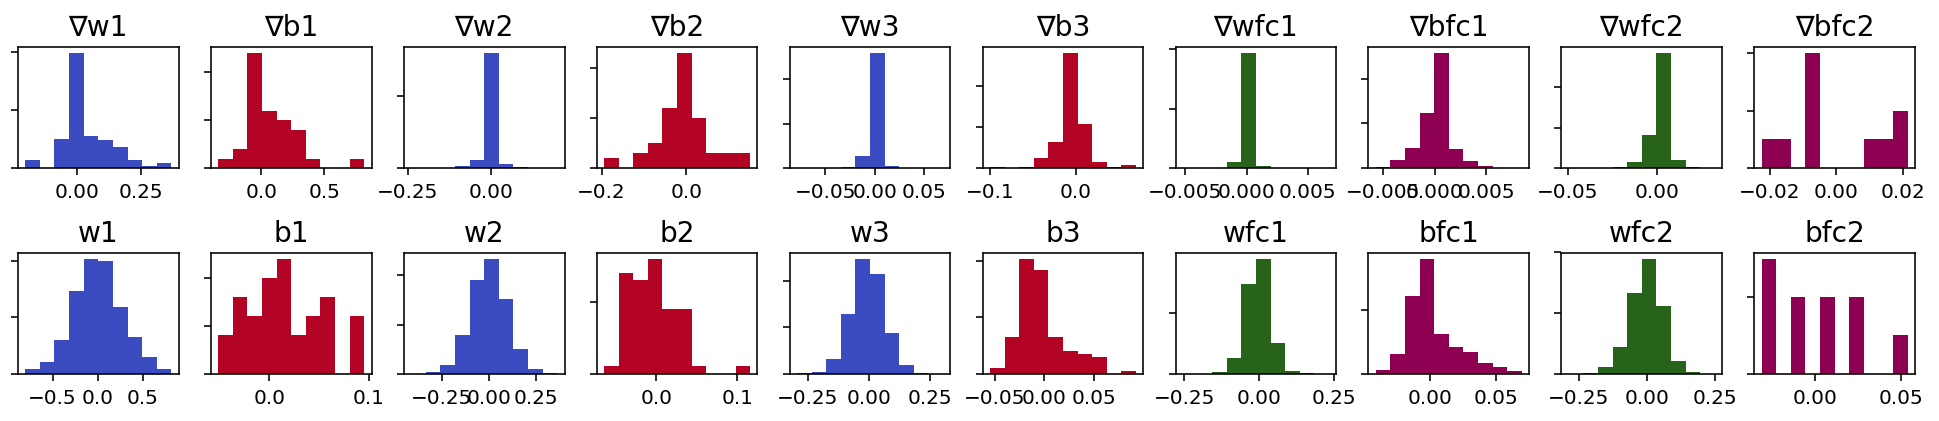

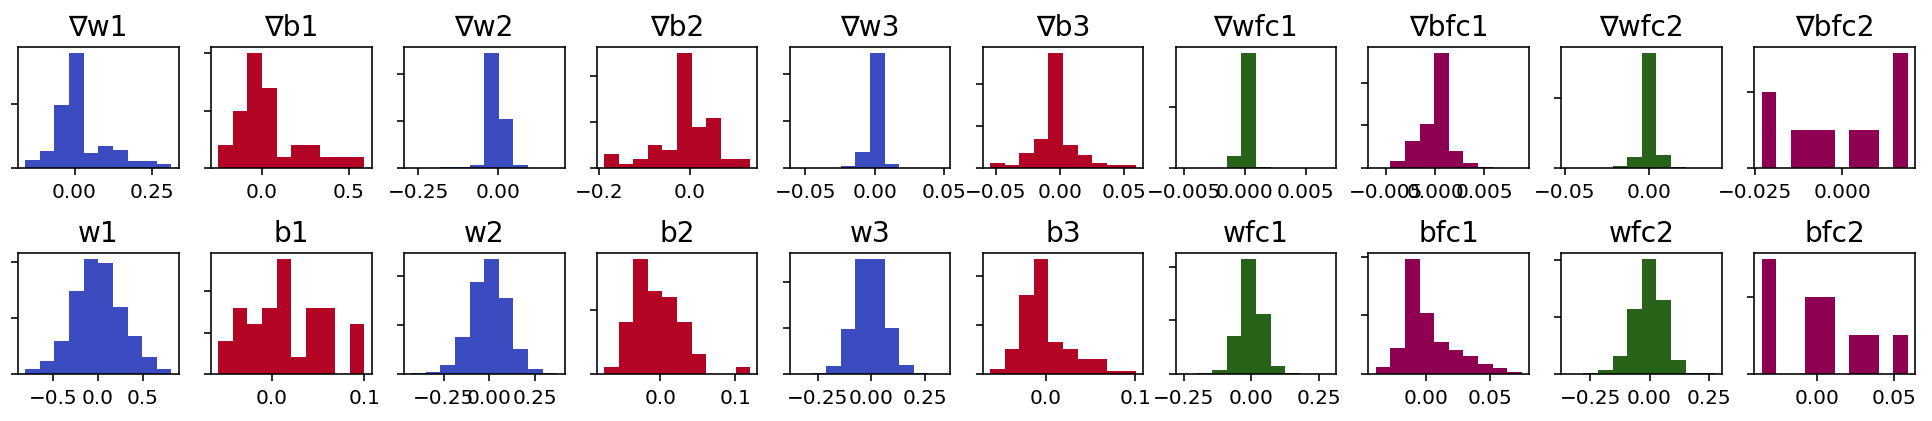

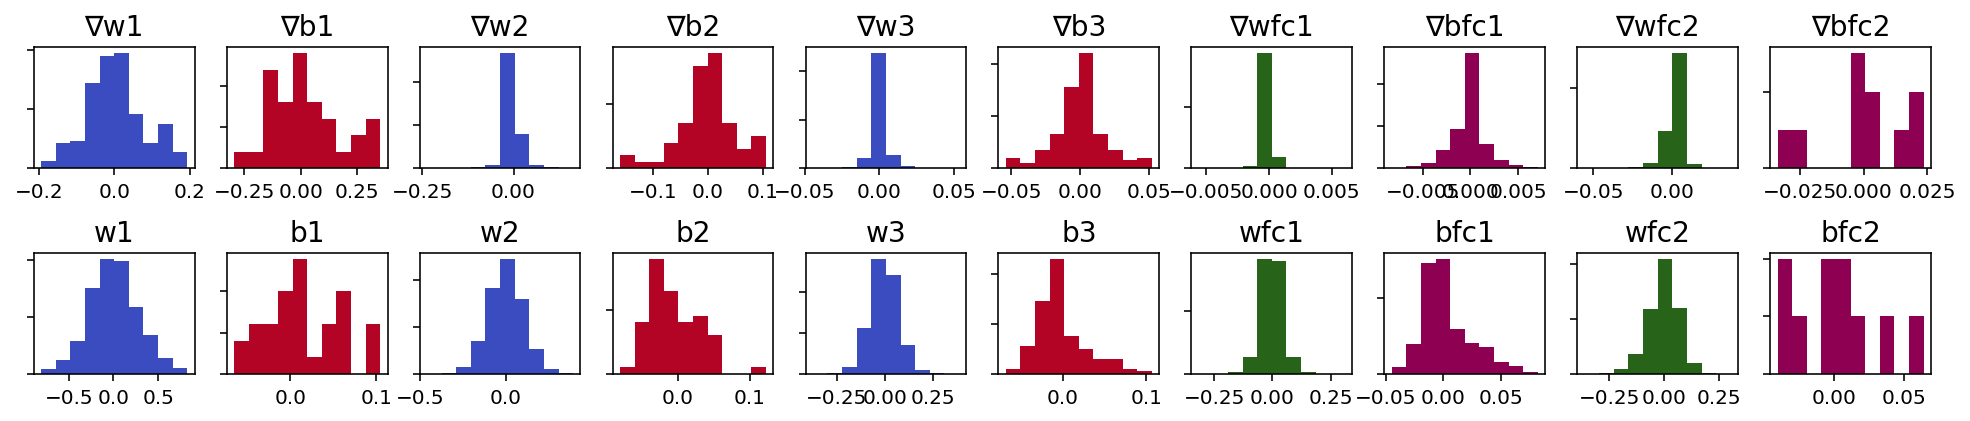

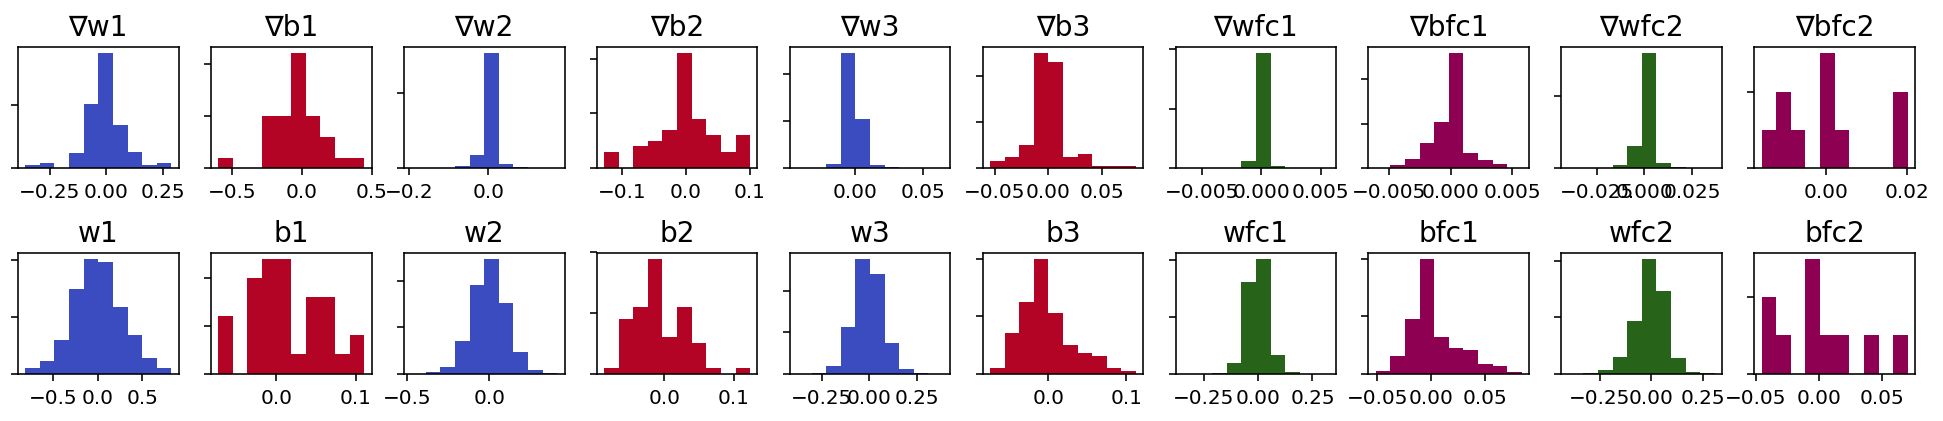

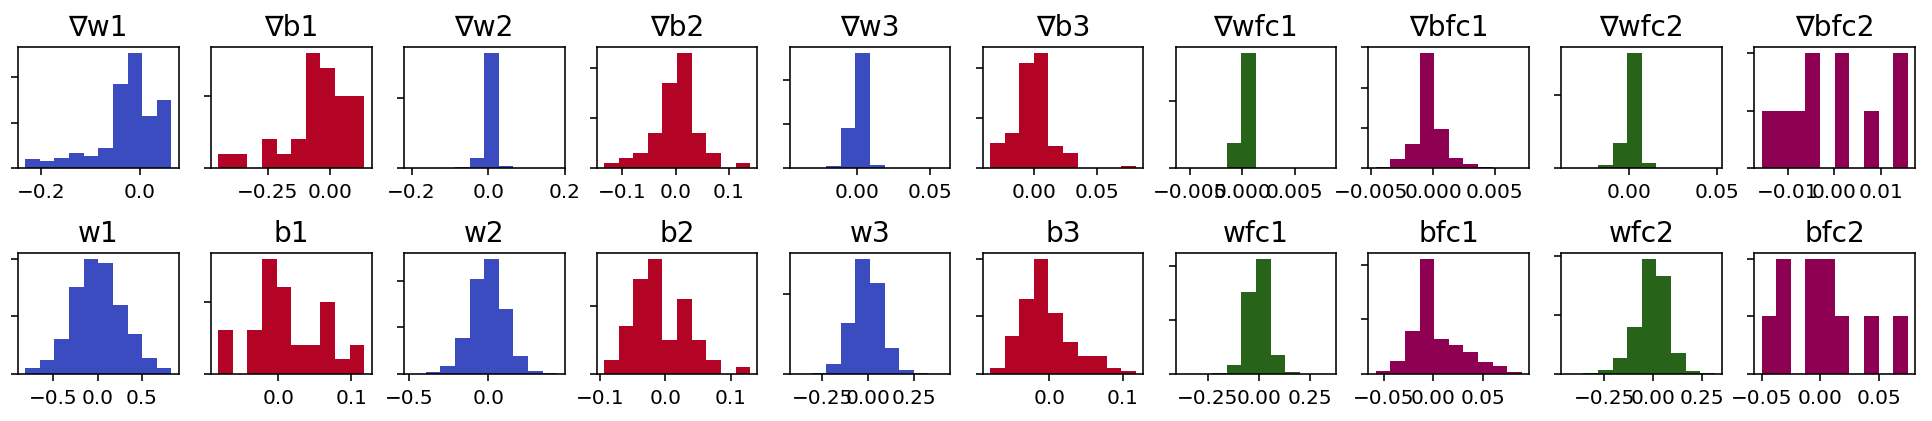

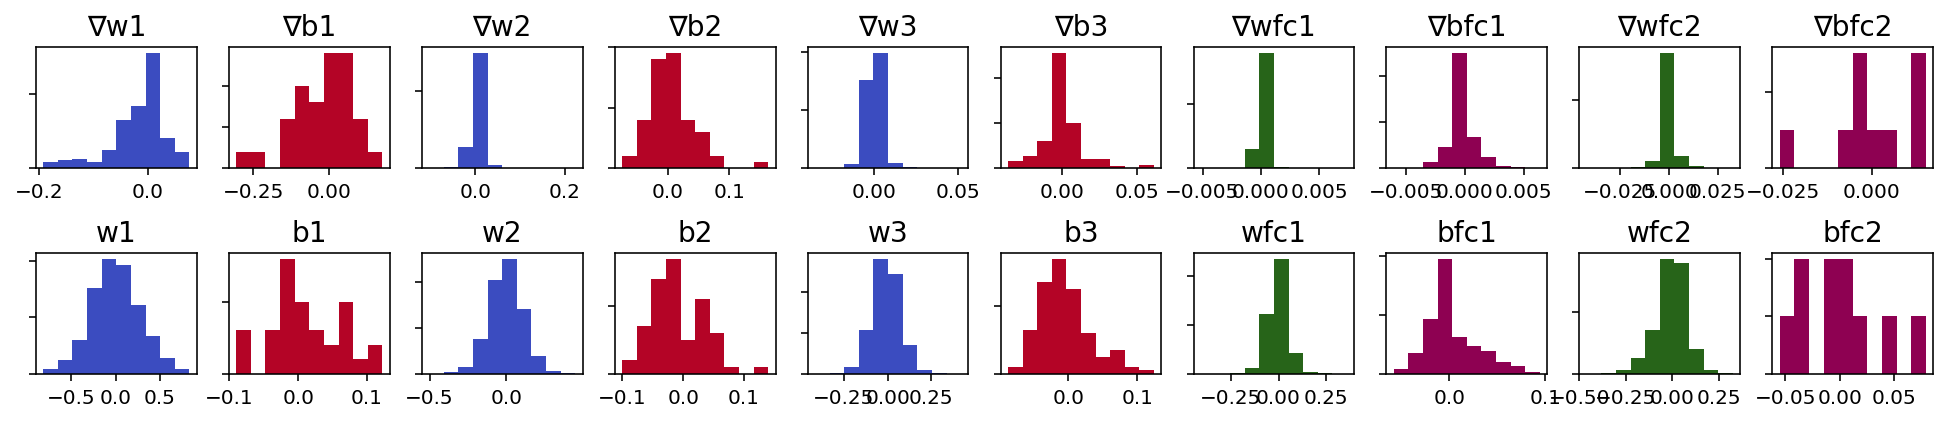

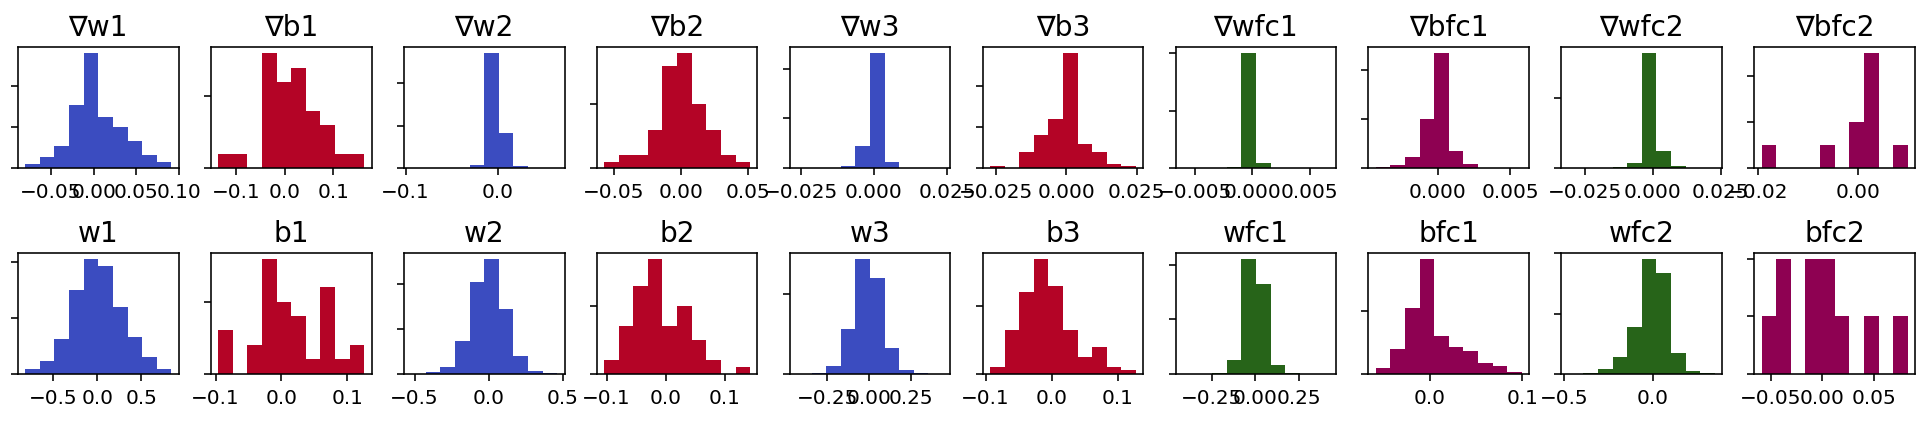

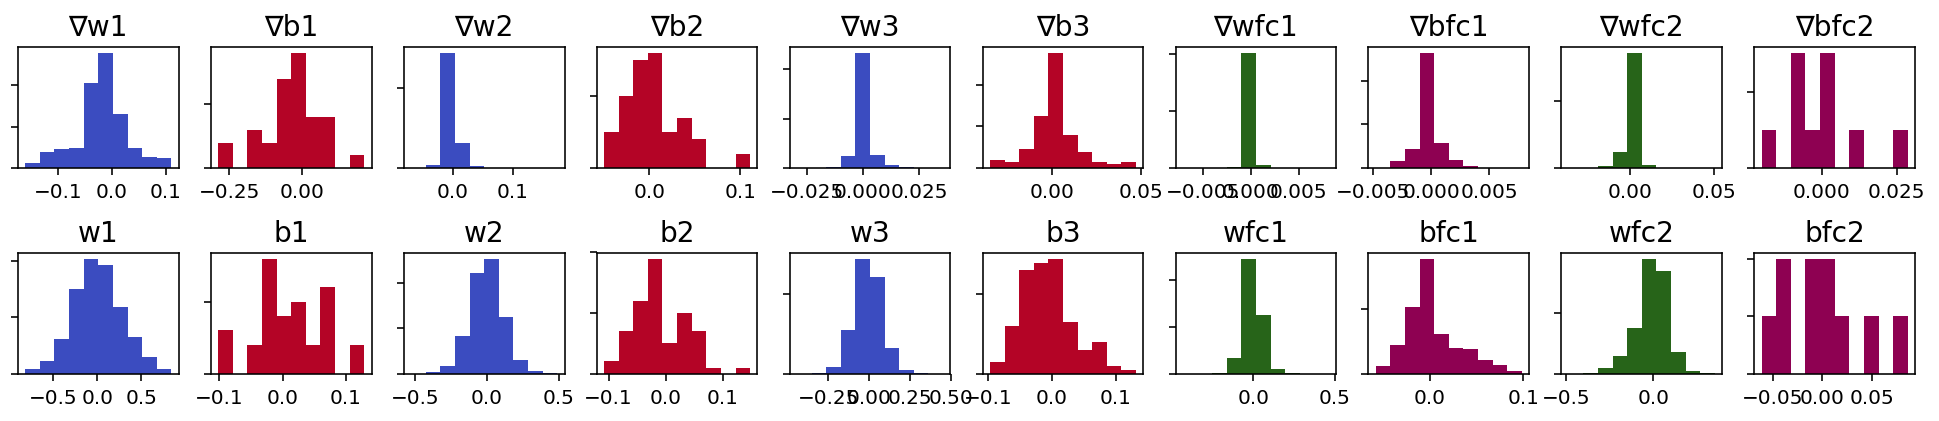

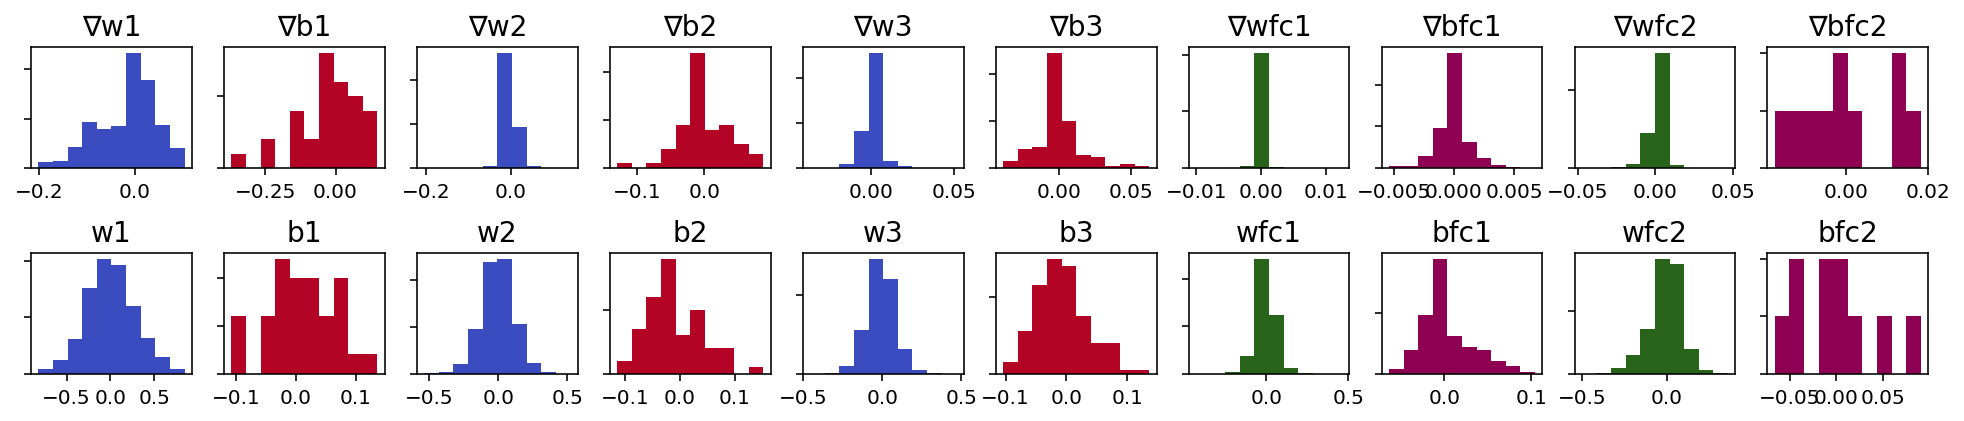

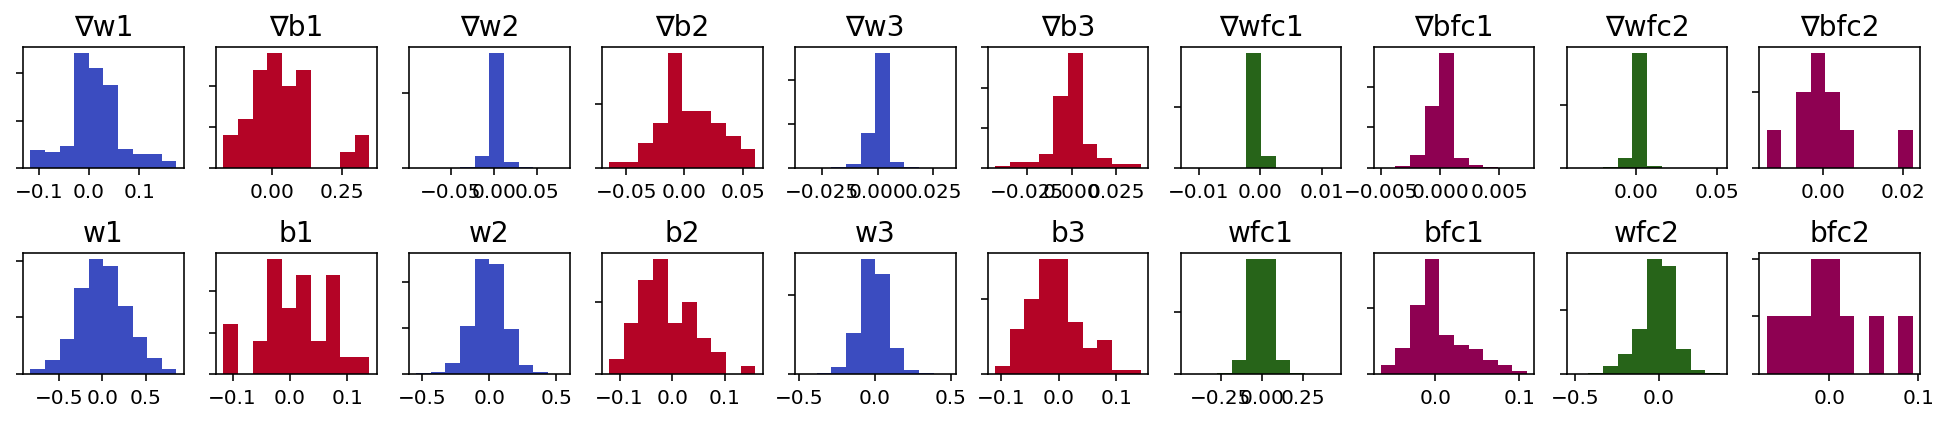

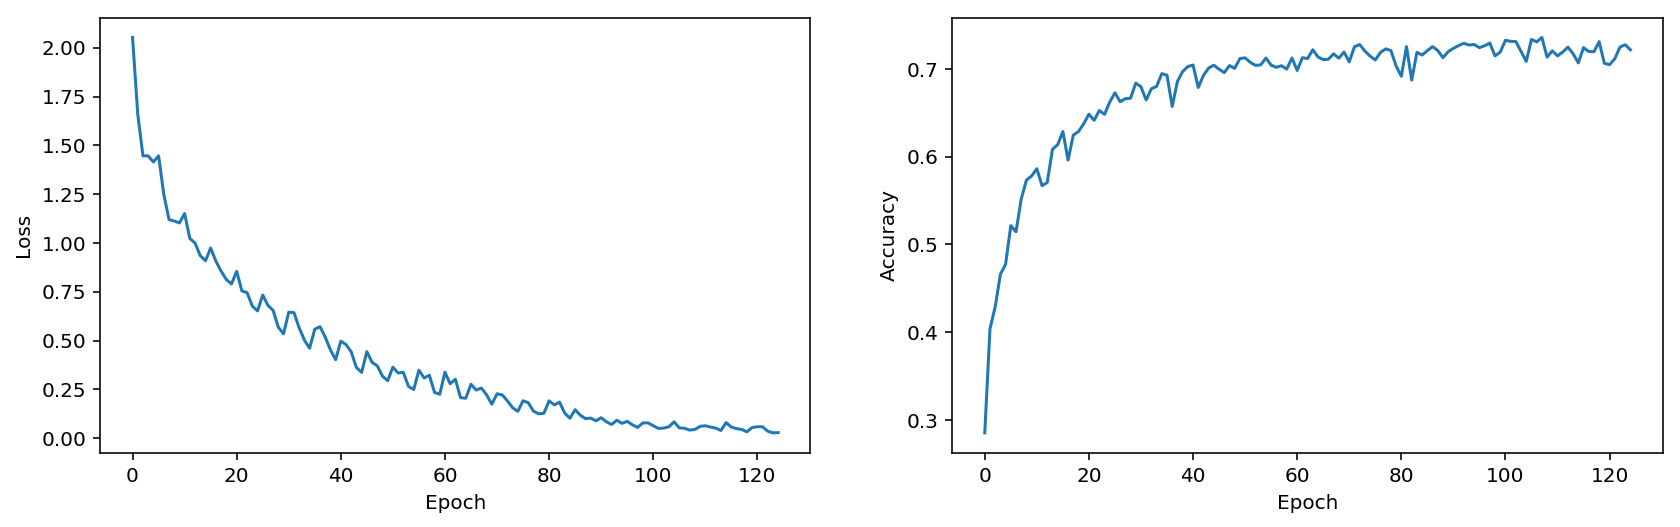

In [25]:
zero_init = lambda shape: tf.zeros(shape)
stddev1   = lambda shape: tf.truncated_normal(shape, stddev=1)
stddev01  = lambda shape: tf.truncated_normal(shape, stddev=0.1)
stddev001 = lambda shape: tf.truncated_normal(shape, stddev=0.01)
stddev0001= lambda shape: tf.truncated_normal(shape, stddev=0.001)

#run(stddev1, zero_init, epochs = 25, batches = 1, title = 'stddev1')
#run(stddev01, zero_init, epochs = 25, batches = 1, title = 'stddev01')
#run(stddev001, zero_init, epochs = 25, batches = 1, title = 'stddev001')
#run(stddev0001, zero_init, epochs = 25, batches = 1, title = 'stddev0001')
run(xavier_inivializer, zero_init, epochs = 25, batches = 5, title = 'xavier_full')

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This will be your final accuracy. You should have an accuracy greater than 50%. If you don't, keep tweaking the model architecture and parameters.

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.7144705414012739



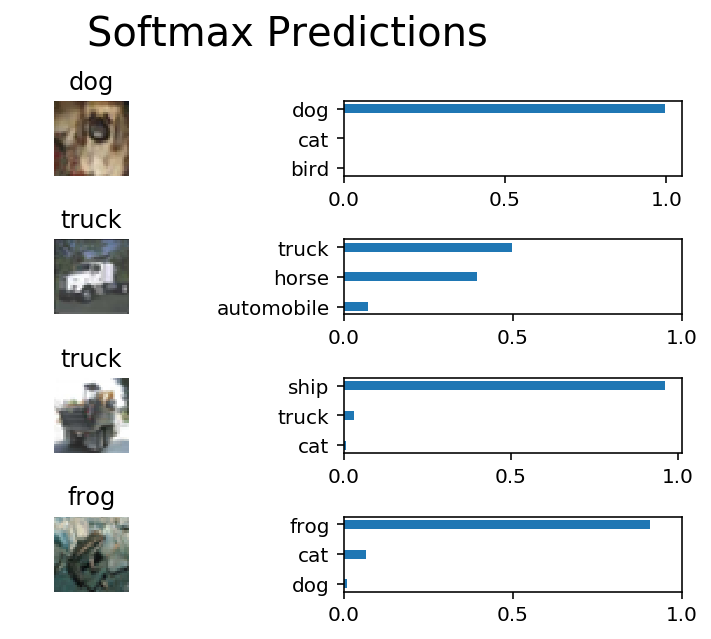

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()